# Lab 0: Introduction to Reddit Data

## Contents
1. [Setup](#Section-1%3A-Setup)
    1. [Import](#1.1-Import-Packages)
    1. [Getting Data](#1.2-Getting-Data)
    1. [Obscenity](#1.3-Obscenity)
1. [Exploring Data](#Section-2%3A-Exploring-Data)
    1. [Variables](#2.1-Variables)
    1. [Distributions](#2.2-Distributions)
1. [Trends over Time](#Section-3%3A-Trends-over-Time)
    1. [Adding Events](#3.1-Adding-Events)
    1. [Events in Detail](#3.1-Events-in-Detail)
1. [Football games](#Sectoin-4%3A-Football-games)

## Section 0: Background
In this lab, we'll cover:
- What reddit data look like
- Several ways to summarize the conversation's tone
- Evaluation of data over time

## Section 1: Setup
### 1.1 Import Packages

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

### 1.2 Getting Data
- Data files with Reddit comments are publicly available many places online, including torrents, google's BigQuery, and several data hosting websites. UM keeps a full copy in our Advanced Research Computing resources.
- Reddit is one of the biggest sites on the internet. 
    - It has over 3.5 billion comments, and the data take up several TB of disk space (`1 TB = 1024 GB`)! 
    - This makes working with the data difficult.
    - For simplicity, we went ahead and used some big data tools like `pyspark` and `hadoop` to go through all the comments and select out smaller sets to work with in this lab. 
- Let's start by looking at just the comments from the subreddit community for the University of Michigan
    - This file is only 34 MB: a more managable size!
    - The `shape` property tells us that there are 66 thousand rows (comments) and 28 columns.

In [2]:
#read the data
um_comments = pd.read_csv('data/merged/uofm.tsv.gz', sep='\t')

#convert our dates to the date data type
um_comments['date'] = pd.to_datetime(um_comments.date)
#show the shape of our table
um_comments.shape

(67699, 29)

### 1.3 Obscenity
- The data for this lab include comments taken from the internet. Some of these comments might have obscene or offensive language in them.
- For the most part, we will look at statistics summarizing the comments.
- Sometimes, though, we will look at example comments chosen at random from the data.
- **Important:** if you do not want to see comments with obscene or offensive language, then change the code in the cell below to say `show_obscene = False`.
    - The code will try to pick examples without obscenity when it is showing random examples. Because people on the internet can type anything, often in unusual ways, we cannot promise every obscene or offensive comment will be filtered out, but a lot of them will be.
    - This has no affect on the statistical analysis.

In [3]:
show_obscene = True

## Section 2: Exploring Data
### 2.1 Variables
What information do we have about each comment?
- We have a lot! Here are some of the most interesting columns:
    - `body` the text of the comment
    - `author` the username of the person who posted it
    - `date` when the comment was made
    - `subreddit` which community a comment is from. Here, they're all from `r/uofm`
    - `politeness` scores, computed by the [Stanford NLP group's software](https://www.cs.cornell.edu/~cristian/Politeness.html), tell us how "polite" a comment is, from 0 (not at all) to 1 (very polite). The program that gives these scores was designed primarily for comments where someone was replying to a request.
        - politeness scores are based on the indication of polite words, phrases, and communication strategies, instead of detecting impolite ones. In other words, 0 politeness does not necessarily mean impoliteness but lack of polite words.
    - `sentiment` (how positive or negative a comment is), computed by the [VADER program in NLTK](http://www.nltk.org/_modules/nltk/sentiment/vader.html). (-1 is very negative, 0 is neutral, and 1 is very positive). 
        - VADER uses a bag of words approach, i.e. a lookup table of positive and negative words. Sentiment is calculated based on the occurrence of negative or positive words in texts, and the intensity of the sentiment will increase if words like “really”, “so” or “a bit” are present.
    - `pej_nouns`: Sometimes when an adjective for people is used as a noun, it takes on a pejorative meaning. Research has found this is often true for the words "female," "gay," "poor," and "illegal," so this column counts the number of times those words (or versions of them like "females") are used as nouns. For more information, see this paper:
        - Palmer, Alexis, Melissa Robinson, and Kristy Philips. 2017. “[Illegal Is Not a Noun: Linguistic Form for Detection of Pejorative Nominalizations](http://www.aclweb.org/anthology/W17-3014).” Pp. 91–100 in *Proceedings of the First Workshop on Abusive Language Online.* Vancouver.
    - Several scores from the [Perspective API](https://www.perspectiveapi.com/). In this project, Google and Jigsaw teamed up to build automatic systems for finding bad comments. We used their program to score these comments already, and the scores are saved in the file.
        - `ATTACK_ON_COMMENTER` the probability that this comment is a personal attack on another commenter 
        - `INCOHERENT` whether the comment seems to make sense (high values don't make sense).
        - `INFLAMMATORY` how inflammatory the comment is
        - `LIKELY_TO_REJECT` the liklihood that New York Times comment editors would reject  the comment if it was posted on their site 
        - `OBSCENE` probability that the comment is obscene
            - Obscene or vulgar language such as cursing.
            - "A higher score indicates a greater likelihood a reader would perceive the comment as containing the given attribute." (From [Perspective API](https://developers.perspectiveapi.com/s/about-the-api-model-cards))
        - `TOXICITY` probability that the comment is 'toxic' for community discussion
            - Perspective defines toxicity as "a rude, disrespectful, or unreasonable comment that is likely to make you leave a discussion." (From [Perspective API](https://developers.perspectiveapi.com/s/about-the-api-model-cards))

In [4]:
um_comments.columns.values

array(['date', 'author', 'body', 'politeness', 'sentiment',
       'controversiality', 'TOXICITY', 'ATTACK_ON_COMMENTER',
       'INFLAMMATORY', 'LIKELY_TO_REJECT', 'OBSCENE', 'SEVERE_TOXICITY',
       'ATTACK_ON_AUTHOR', 'SPAM', 'UNSUBSTANTIAL', 'INCOHERENT',
       'pej_nouns', 'ups', 'edited', 'id', 'is_submitter', 'parent_id',
       'replies', 'score', 'subreddit', 'deleted', 'stickied', 'archived',
       'collapsed'], dtype=object)

In [5]:
um_comments.head()

,date,author,body,politeness,sentiment,controversiality,TOXICITY,ATTACK_ON_COMMENTER,INFLAMMATORY,LIKELY_TO_REJECT,...,id,is_submitter,parent_id,replies,score,subreddit,deleted,stickied,archived,collapsed
0,2016-12-18 03:59:06,NinetyNine90,On the bright side it makes getting campus job...,0.500000,0.5617,0,0.097784,0.592016,0.498771,0.285933,...,dbbx41l,NaN,t1_dbbla80,NaN,39,uofm,0,False,NaN,NaN
1,2016-12-18 04:03:19,Ivor97,Wolverine Access is great. It's just really u...,0.437878,0.0343,0,0.607831,0.239917,0.450659,0.352783,...,dbbx9b9,NaN,t1_dbbwd0l,NaN,29,uofm,0,False,NaN,NaN
2,2016-12-18 04:22:56,Shadowhawk109,IIRC spring break coincides with project 3 of ...,0.452687,0.3548,0,0.027826,0.265231,0.363987,0.583996,...,dbbxxb7,NaN,t3_5ivbxv,NaN,4,uofm,0,False,NaN,NaN
3,2016-12-18 04:31:29,[deleted],[deleted],NaN,NaN,0,NaN,NaN,NaN,NaN,...,dbby7ol,NaN,t1_dbbla80,NaN,4,uofm,1,False,NaN,NaN
4,2016-12-18 04:33:34,1gaybro,In my experience the Greyhound picks you up at...,0.494651,0.0000,0,0.030083,0.727338,0.182881,0.490436,...,dbbya6k,NaN,t3_5iyj2y,NaN,5,uofm,0,False,NaN,NaN


#### Example comments
- This randomly selects one of the comments and shows the text. 
- Run it multiple times to see different randomly chosen comments

In [48]:
print(um_comments.sample(1).body.iloc[0])

There are private conference rooms and study rooms in the Duderstadt.


#### Helper function for finding examples of comments that score high or low
Run this code and scroll down.

In [7]:
def get_example(data, column, where='high', show_obscene=True):
    #pick whether to use high or low scoring comments
    if where == 'high':
        asc = False
    else:
        asc = True
    #Select the 100 most extreme comments in this column
    df = data.sort_values(by=column, ascending=asc).head(100)
    
    if not show_obscene:
        df = df[df.OBSCENE < 0.1]
    
    if df.shape[0] > 0:
        #pick one at random and print the text of it
        print(df.sample(1).body.iloc[0])
    else:
        print('No comments meet your search criteria.')
        if not show_obscene:
            print('The obscenity filter might be hiding these comments. You can try turning it off if you would like to read them. Simply set "show_obscene=True"')
        
    return

#### Short Answer 1:
#### What do all those scores mean? (They're not perfect!)
- **Run the code below, trying different column names** to see examples of comments that scored high or low in each measure.  
    - The function `get_example()` picks a comment at random, so run it more than once with `alt`+`enter` and you'll see different comments.
    - Look for patterns in the types of comments that come up.
    - Do any of the scores seem to mean something a little different than you expected? Pick **two scores** that were the most surprising. In a few sentences for each one, tell us **which** score you chose, and **what** was surprising about the comments that came up for that score, and **why**.

In [8]:
get_example(data=um_comments, column='sentiment', where='high', show_obscene=show_obscene)

Sounds good then :D , thanks for all the help mate.


In [9]:
get_example(data=um_comments, column='sentiment', where='low', show_obscene=show_obscene)

I got an A on his 270 class, and he sucks a lot, one of the worst professors I have had, if not the worst, at UM. I dunno how his research goes or other aspects about him, but as a teacher, he is really bad.


In [10]:
get_example(data=um_comments, column='politeness', where='low', show_obscene=show_obscene)

Apparently I am out of touch - what is Mary Sue Coleman's "bullshit"?


In [11]:
get_example(data=um_comments, 
            column='ATTACK_ON_COMMENTER', where='high', show_obscene=show_obscene)

How ignorant do you have to be to not recognize that your own coach wears khakis on the sideline? Buckeye fans are odd people.


In [12]:
get_example(data=um_comments, column='TOXICITY', where='high', show_obscene=show_obscene)

Lol  Fuck off OP


In [13]:
get_example(data=um_comments, column='OBSCENE', where='high', show_obscene=show_obscene)

haha. dem bounds will fuck you errytime.  I have a piece of paper with my objects and how their right turn costs were changing as they were being built up by the modified A*/Dijkstra b&amp;b tree.  It seriously just fucked my brain for like a full day.


🤔**Write your response here:**
....

- Note that the scores don't always seem right. For example, sometimes a comment that scored high in `ATTACK_ON_COMMENTER` isn't actually a personal attack.
    - The scores were made by some of the most advanced software for this in the world, and they're still not perfect. This reminds us just how hard it is for computers to understand human language.
- Still, most of the scores seem about right. And, as we know from statistics, we can still make inferences about average scores even when there are some errors in our measurements.

### 2.2 Distributions
Getting a feel for our data
- One of the first things to do with any data is plot it. We want to get a feel for what's in it and how it is spread out (i.e. how it is distributed). Take a look at the histograms below.
- Below, we plot the distribution of sentiment scores and the distribution of obscentity scores.
- There are a few important things to notice:
    - Sentiment ranges from -1 to +1. That is, people can make very negative or very positive comments, or anything in between.
    - Sentiment looks like what we call a "normal distribution" or a "bell curve." Most sentiment scores are around 0.2. Only a small number of comments have an extremely negative or extremely positive score.
    - There is a big "spike" at 0 for sentiment. Usually, when you see a something like this in data is is a result of how the measurements were taken. In this case, comments get a score of 0 if they don't seem to have a positive or negative sentiment. For example:
        - "UM has too many students" is negative.
        - "UM has 46,000 students" is neither positive nor negative.
        - "It is good that we have so many students" is positive.
        - "It is amazing that we have such an excellent number of brilliant students" is much more positive.
    - Our obscenity score is different. It ranges from 0 to 1, and it has a spike at both extremes. That is because of how it was measured. The score is designed to answer a yes or no question: "Is this obscene?" If yes, it should give a score of 1, and if no, it should give a score of 0. When it is not sure, it gives a score in between. 

#### Short Answer 2:
- Look at the graph for `politeness`. 
- 1. In a few sentences, say what a score of 0 politeness would mean. Compare this with a score of 0 in `sentiment` and 0 in `OBSCENE`.
- 2. Write a few sentences comparing what 0.5 means in the three different scores.

<AxesSubplot:>

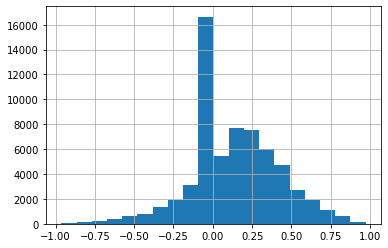

In [14]:
um_comments.sentiment.hist(bins=20)

<AxesSubplot:>

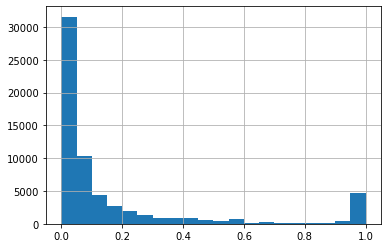

In [15]:
um_comments.OBSCENE.hist(bins=20)

<AxesSubplot:>

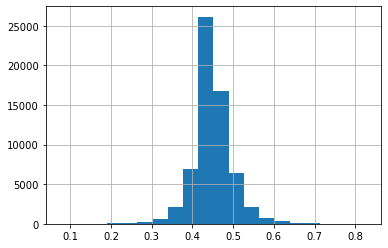

In [16]:
um_comments.politeness.hist(bins=20)

🤔**Write your response here:**
....

## Section 3: Trends over Time
- In this lab, we're not just interested in individual comments, but in the community (in this case, a subreddit forum) and how it changes over time. 
- To study this, we're going to be using the `groupby` and `resample` functions in pandas. They're two slightly different functions that do the same basic thing:
    - Take all of our comments and put them into groups (in our case, one group for each month).
    - Summarize each group (e.g. by telling us how many comments are in it or what their average score is).
- Once we have summaries for each group, we can plot them on a graph where the X axis is time. Take a look at the examples below.

<AxesSubplot:title={'center':'Number of comments posted'}, xlabel='date'>

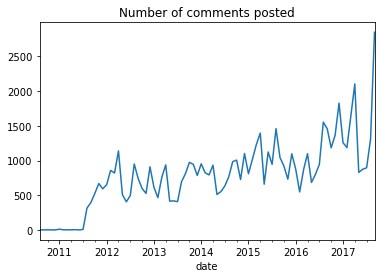

In [17]:
#Group the comments by month
monthly = um_comments.resample('M', on='date')

#count the number of comments in ach group
total_comments = monthly.body.count()

#show first few months
total_comments.plot(title='Number of comments posted')

#### We can make the plots prettier with this helper function.
Don't worry about how this code works, just run it and scroll down.

In [18]:
def make_plot(grouped, columns='id', title=None, top=None, bottom=None, 
             games=None, exams=None, classes=None, agg='mean',
             years=[2012, 2018]):
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
    
    if years is not None:
        axs.set_xlim(left=datetime(year=years[0], month=1, day=1), 
                     right=datetime(year=years[1], month=1, day=1))
    
    if games is not None:
        for g in games.iterrows():
            if g[1].game_result == 'W':
                axs.axvline(g[1].date, color='k', alpha=.6)
            elif g[1].game_result == 'L':
                axs.axvline(g[1].date, color='r', alpha=.6)
                
    if exams is not None:
        for e in exams.iterrows():
            if e[1].exams == 1:
                axs.axvline(e[1].date, color='r', alpha=.5)
                
    if classes is not None:
        for c in classes.iterrows():
            axs.axvspan(c[1].class_start, c[1].class_end, 
                        color='g', alpha=0.35)
                
    if isinstance(columns, str):
        columns = [columns]
        
        
    if agg == 'mean':
        for c in columns:
            means = grouped[c].mean()
            sems = grouped[c].sem()
            axs.plot(means.index, means, label=c)
            axs.fill_between(sems.index, means-(1.96*sems), 
                             means+(1.96*sems), alpha=0.5)

        axs.set_ylabel('Score')
        axs.legend()
        if title is None:
            title = 'Average scores with 95% confidence interval'
            
    elif agg == 'count':
        for c in columns:
            counts = grouped[c].count()
            axs.plot(counts, label=c)
        if title is None:
            title = 'Number of comments per month'
        axs.set_ylabel('Count')
        
    elif agg == 'unique':
        for c in columns:
            counts = grouped[c].nunique()
            axs.plot(counts, label=c)
        if title is None:
            title = 'Number of unique ___ per month'
        axs.legend()
        axs.set_ylabel('Count')
        
    axs.set_title(title)
    axs.set_xlabel('Time')
                
    plt.show()
    return

def show_correlation(df, s1, s2):
    tmp = df[['TOXICITY', 'sentiment']].mean()
    tmp = tmp[tmp.index > datetime(year=2012, month=1, day=1)]
    c = tmp.corr()
    print("Correlation is:", c.iloc[0,1].round(2))
    return

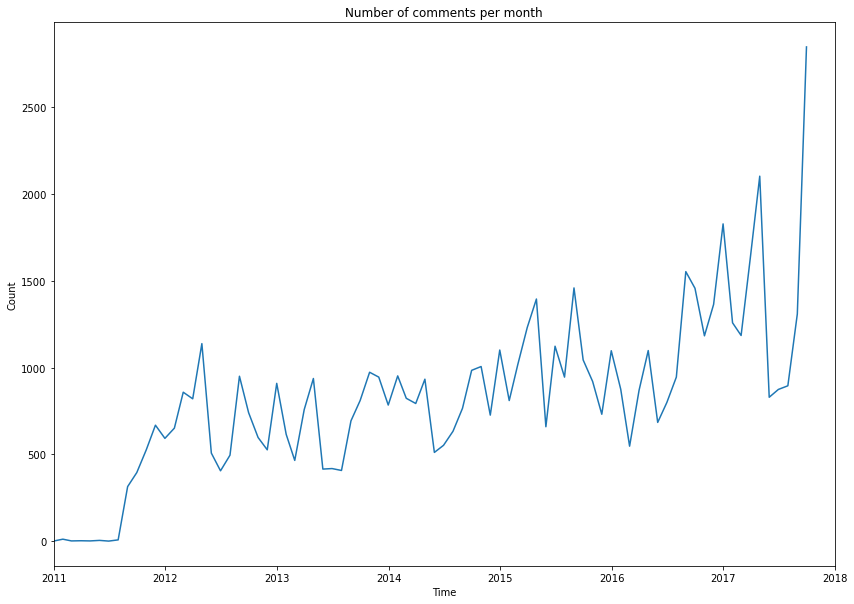

In [19]:
make_plot(monthly, agg='count', years=[2011,2018])

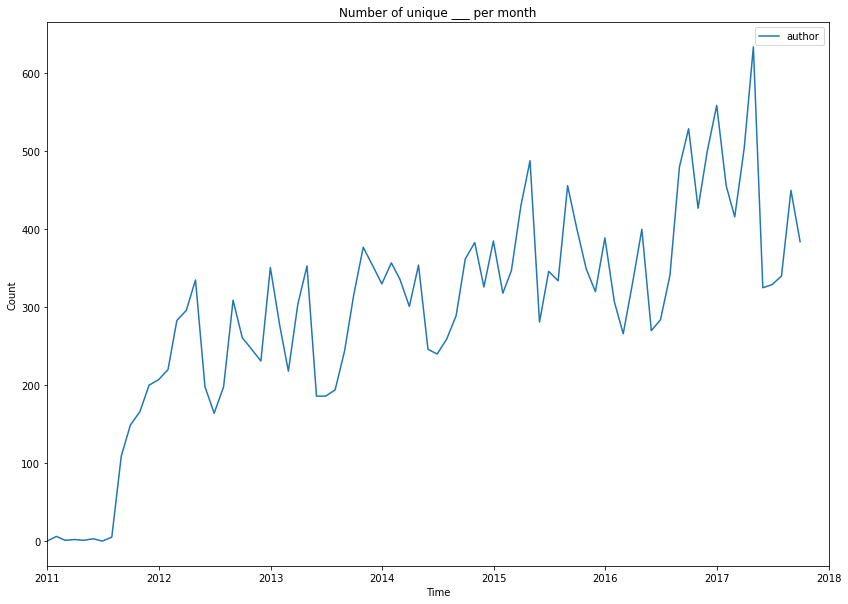

In [20]:
make_plot(monthly, columns='author', agg='unique', years=[2011,2018])

#### Short answer 3:
- Do you notice a pattern in the number of comments or active users over time?
    - It is a little messy, but it seems like there are fewer people posting comments in the middle of each year (summer time). In 1-2 sentences, say why that might be happening. 

🤔**Write your response here:**
....

#### What about the comment scores? 
- We can plot the average score of comments each month.
- Because the score is an average, it also has a standard error.
- We'll write a simple helper function to make nice plots of the averages and the confidence interval around them.


##### Try it Yourself
- Call the function `make_plot()` with different column names to see different plots. 
- You can also call it with multiple column names in a list, like in the third example.
- **Hint** you can change the range of the y axis by setting the arguments `top` and `bottom`. Otherwise they'll be chosen automatically. 

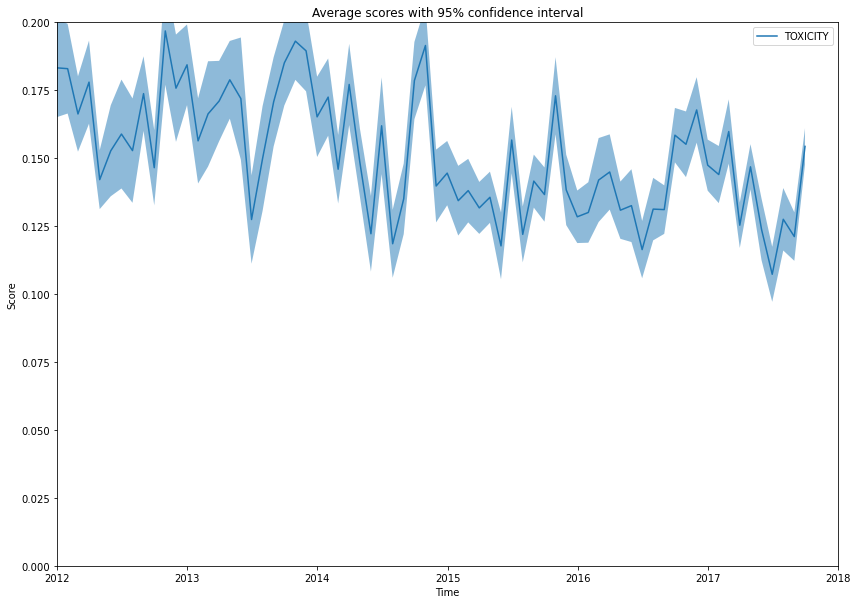

In [80]:
make_plot(monthly, columns='TOXICITY', top=.2)

#### Short answer 4:
- 1. Create a cell below and copy and paste the code above. Change the range of the y axis by setting the arguments `top` and `bottom` to produce a nice-looking plot for toxicity.
- 2. Pick another score and replace the `column name` by the score you pick. Produce a nice-looking plot for the score you pick. 

🤔**Write your response here:**
....

#### Short answer 5:
- In the example below, we see toxicity and sentiment seem to have an inverse relationship: when one goes up, the other goes down. (In fact, the correlation is -0.81.)
    - 1. Why might this be? Write a few sentences.
- 2. Try different combinations of variables: do other scores seem to have a relationship like this?
    - Pick **two pairs** of scores. In a few sentences each, write which you picked, whether there seems to be a relationship between them, and why that might be.

Correlation is: -0.81


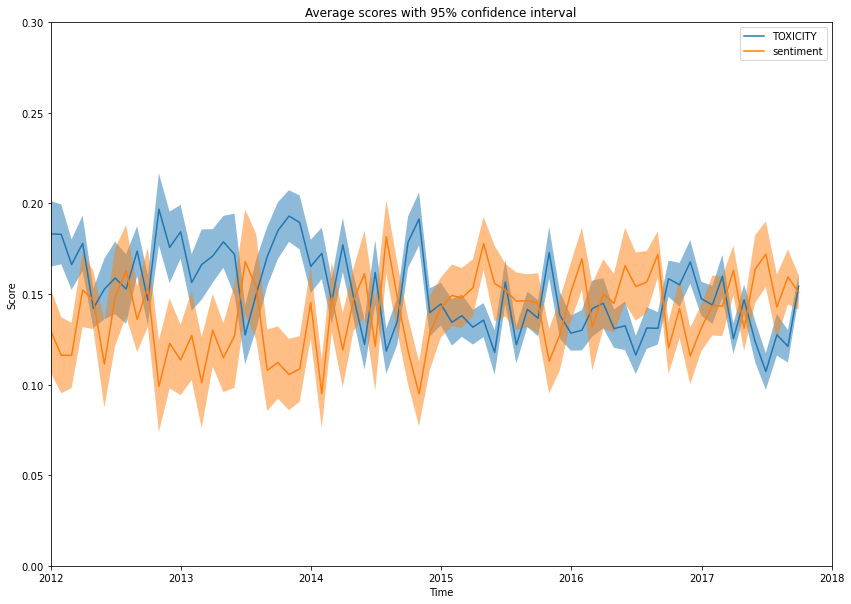

In [22]:
score_1 = 'TOXICITY'
score_2 = 'sentiment'

show_correlation(monthly, score_1, score_2)
make_plot(monthly, columns=[score_1, score_2], top=.3)

🤔**Write your response here:**
....

### 3.1 Adding Events
- Maybe some of the patterns we see in the data corrispond to events happening at the same time. 

#### Let's load data about when UM classes are in session 

In [23]:
#read data
classes = pd.read_csv('data/UM_class_periods_no_summer.tsv', sep='\t')
#convert dates to date data type
classes['class_start'] = pd.to_datetime(classes.class_start)
classes['class_end'] = pd.to_datetime(classes.class_end)
#show the most recent information
classes.tail()

,class_start,class_end
56,2017-09-05,2017-11-22
57,2017-11-27,2017-12-12
58,2018-01-03,2018-02-24
59,2018-03-05,2018-04-17
60,2018-09-04,2018-11-21


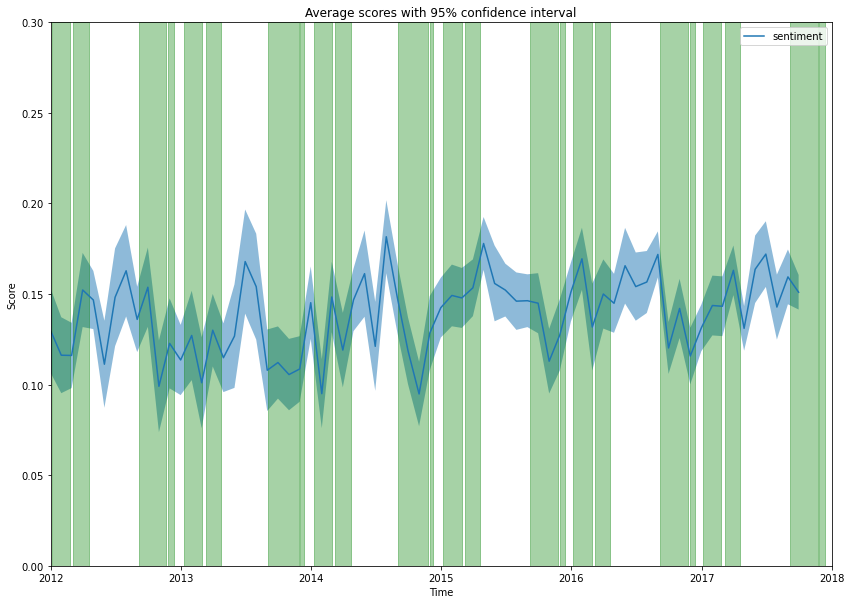

In [24]:
make_plot(monthly, columns=['sentiment'], classes=classes, top=.3)

#### See a pattern?
- The graph is green during times when classes are in session, and white otherwise.
- Sentiment on the r/uofm subreddit seems to get more negative when Summer ends and Fall semester begins each year.

#### Short Answer 6:
- Does that happen for the other scores? **Try the function with different column names** instead of `sentiment` to see. 
- 1. List the scores where it looks like their might be a pattern related to when classes are in session.
- 2. Pick **two scores** and write a few sentences for each about why you do (or don't) see a relationship between the score and class times.

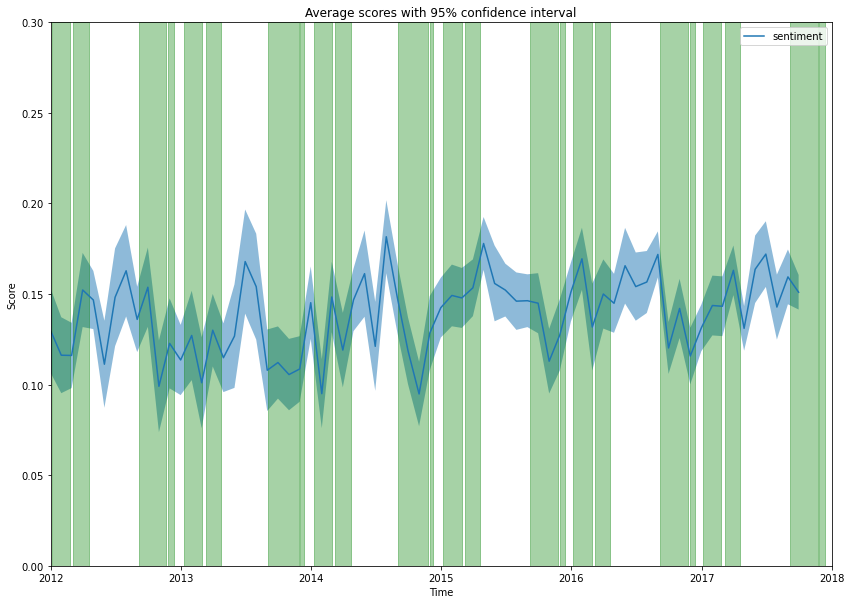

In [25]:
make_plot(monthly, columns=['sentiment'], classes=classes, top=.3)

🤔**Write your response here:**
....

### 3.2 Events in Detail
#### What about final exams?
- Load data on exams

In [26]:
exams = pd.read_csv('data/UM_academic_calendar_no_summer.tsv', sep='\t')
exams['date'] = pd.to_datetime(exams.date)
exams.tail()

,event,times,date,exams,class_start,class_stop
325,Classes resume 8:00 a.m.,"Nov 26, Mon",2018-11-26,0,1,0
326,Classes end,"Dec 11, Tues",2018-12-11,0,0,1
327,Study Days,"Dec 12, Wed & Dec 15-16, Sat-Sun",2018-12-12,0,0,0
328,Examinations,"Dec 13-14, Thur-Fri & Dec 17-20, Mon-Thur",2018-12-13,1,0,0
329,Commencement,"Dec 16, Sun",2018-12-16,0,0,0


#### Helper functions
- Don't worry about how this code works, just run it and scroll down.

In [27]:
def make_plot2(grouped, columns='id', title=None, 
               top=None, bottom=None, colors='vega',
               agg='mean', names = None):
    
    color_sets = {'UM': ['#024794', '#ffcb05', '#83b2a8',
                         '#989c97', '#7a121c'],
                  'vega': ['#1f77b4', '#ff7f0e', '#2ca02c', 
                           '#d62728', '#9467bd', '#8c564b',
                           '#e377c2', '#7f7f7f', '#bcbd22']}
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
                
    if isinstance(columns, str):
        columns = [columns]
    
    if not isinstance(grouped, list):
        grouped = [grouped]
        names=['']
        
    scheme = color_sets[colors]
          
    axs.axvline(0, color='k', linestyle='dashed', alpha=.5)
    i = 0
    for g, n in zip(grouped, names):
        if agg == 'mean':
            for c in columns:
                means = g[c].mean()
                sems = g[c].sem()
                axs.plot(means.index, means, color=scheme[i],
                         label=n+' '+c)
                axs.fill_between(sems.index, means-(1.96*sems), 
                                 means+(1.96*sems), 
                                 color=scheme[i], alpha=0.5)
                i += 1
            axs.legend()
            axs.set_ylabel('Score')
            if title is None:
                title = 'Average with 95% confidence interval'
                
        elif agg == 'count':
            for c in columns:
                counts = g[c].count()
                axs.plot(counts, color=scheme[i], label=n+' '+c)
                i += 1
            if title is None:
                title = 'Number of comments'
            axs.set_ylabel('Count')
            
        elif agg == 'stacked':
            totals = None
            for c in columns:
                if totals == None:
                    totals = g[c].count()
                else: 
                    totals = totals + g[c].count()
            
            for c in columns:
                pcts = g[c].count() / totals
                axs.plot(pcts, color=scheme[i], label=n+' '+c)
                i += 1
                
            if title is None:
                title = 'Percent of comments'
            axs.set_ylabel('Percent')
            
        elif agg == 'unique':
            for c in columns:
                counts = g[c].nunique()
                axs.plot(counts, color=scheme[i], label=n+' '+c)
                i += 1
            if title is None:
                title = 'Number of unique ___'
            axs.set_ylabel('Count')
            axs.legend()

    axs.set_title(title)
    axs.set_xlabel('Days from Event')
                
    plt.show()
    return

def center_on_dates(comments, dates, window_size=14):
    subset = []
    for d in dates.date:
        start = d - pd.Timedelta(window_size, unit='d')
        end = d + pd.Timedelta(window_size+1, unit='d')
        tmp = comments[(comments.date >= start) & 
                          (comments.date <= end)].copy()
        tmp['days'] = tmp.date.apply(lambda x: (x - d).days)
        subset.append(tmp)

    subset = pd.concat(subset)
    return subset.groupby(by='days')

def get_example_from_day(grouped, day=0, search=None, show_obscene=True):
    # ungroups data
    tmp = grouped.apply(lambda x: x.sample(frac=1))
    # Selects desired day
    tmp = tmp[tmp.days == day]
    # optionally filters obscenity
    if not show_obscene:
        tmp = tmp[tmp.OBSCENE < 0.1]  
    # optionally searches for specific words
    if search is not None:
        tmp = tmp[tmp.body.str.contains(search, na=False)]  
        
    if len(tmp) > 0:
        tmp = tmp.sample(1).body.values[0]
    else:
        tmp = 'Sorry, there are no comments matching your search. Try another search or day.'
        
    print(tmp)
    return

In [28]:
exam_weeks = center_on_dates(um_comments, exams)

#### Plots showing posts one week before and after finals start
- The vertical bar shows when finals start.
    - Note that we added together the two weeks before and after finals for every semester, so what you see is the total over all. That's why the X axis is "days since exams started" rather than a specific date.

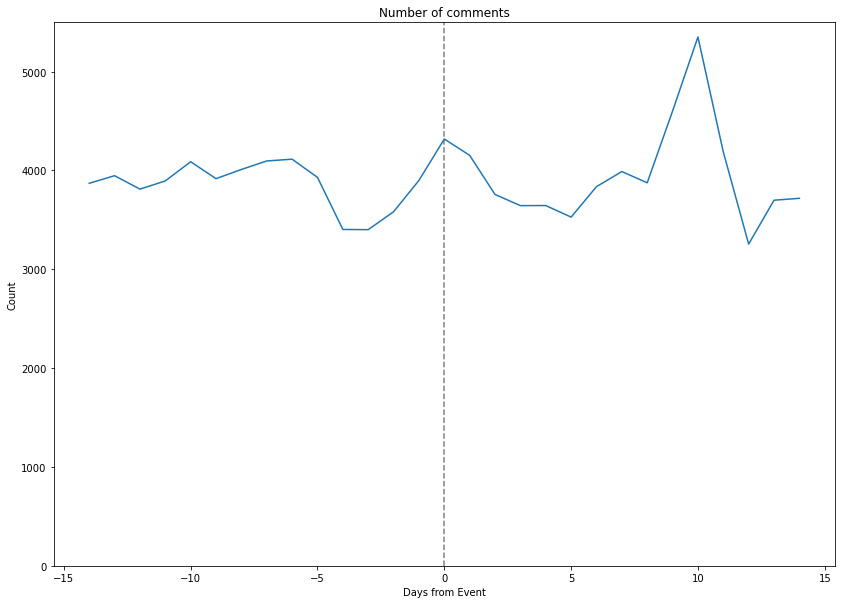

In [29]:
make_plot2(exam_weeks, agg='count', bottom=0, top=5500)

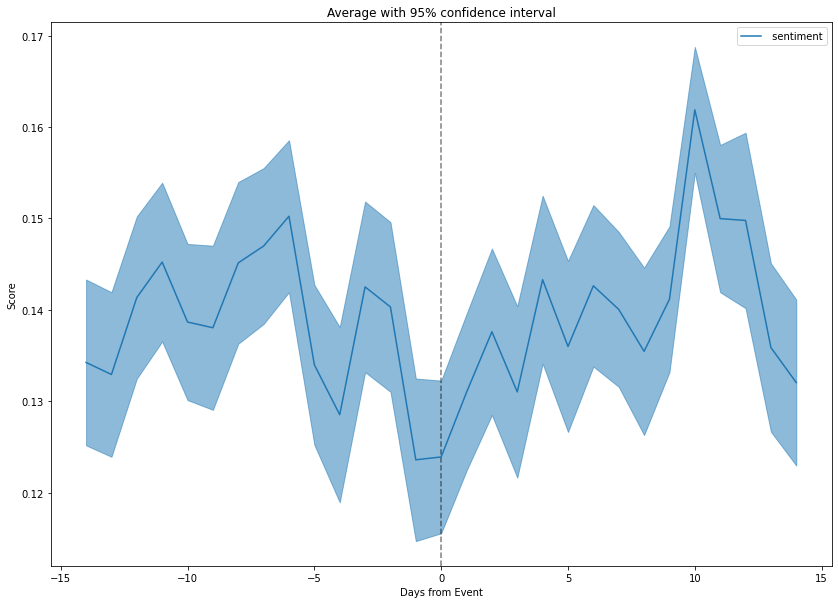

In [30]:
make_plot2(exam_weeks, columns='sentiment')

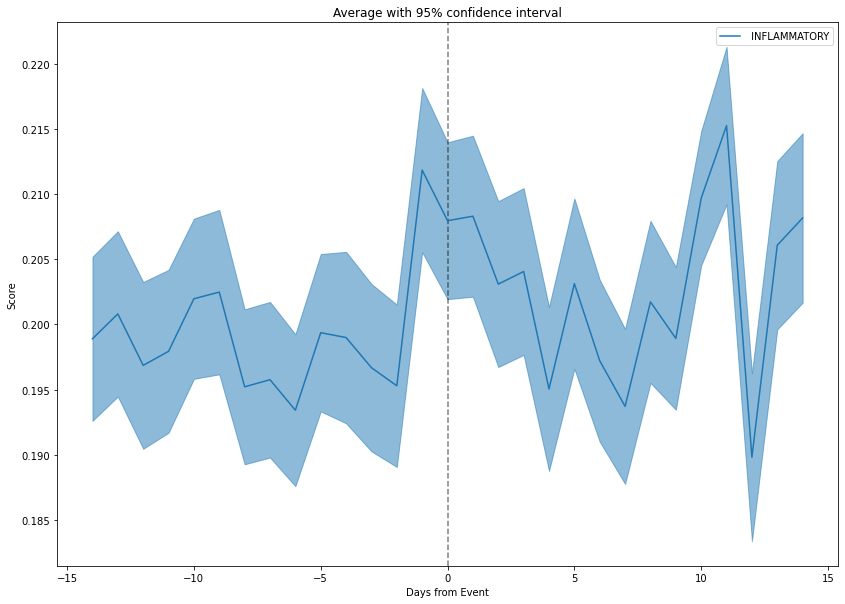

In [31]:
make_plot2(exam_weeks, columns='INFLAMMATORY')

#### Short Answer 7:
Interpreting these graphs
- Pick **two scores** that look like they have an interesting pattern.
- What might be causing these two patterns? Write a few sentences for each, telling us **what** the score is and **explaining your hypothesis**.

🤔**Write your response here:**
....

#### Short Answer 8: 
- Test your answers by looking at example posts from some of these days:
    - Run the functions below multiple times: they will show you random posts from whatever day you ask for. The first shows a random comment. The second shows a random comment that includes a specific word.
    - Try different days and words.
- For **each of the two patterns** you observe in Short Answer 6, example comments support your hypotheses? For each, write a few sentences saying why or why not.

In function "get_example_from_day", you can change the number you input for "day", which indicates how many days from the event (in our case, the event is final exam) the comment is from. Optionally, you may want to look at comments that contain specific words. You can specify the word that you want to search for in "search". For example, you might want to look at comments that contain the word "finals".

In [79]:
get_example_from_day(exam_weeks, day=10, show_obscene=show_obscene)

1. Askwith Media Library. A huge library of Moveis, especially if you have a Blu-ray player http://guides.lib.umich.edu/c.php?g=283244&amp;p=1886778  2. Dude's Video Game Library. Well, they have a ton of games (board games and video games) and you can play right there! https://www.lib.umich.edu/computer-video-game-archive  3. Sunlamps and Massage Chairs apparently at the Union at Caps


In [77]:
get_example_from_day(exam_weeks, day=-1, show_obscene=show_obscene)

It is supposed to become an annual event!  They're even hoping to expand it next year so that more people can participate.


In [67]:
get_example_from_day(exam_weeks, day=-3, search='finals', show_obscene=show_obscene)

When I took it (F15) the final was much more difficult than the midterms. Definitely redo the midterms and do as many practice finals as you can.


🤔**Write your response here:**
....

## Section 4: Football games
- Load data from the subreddit for UM athletics, `r/MichiganWolverines`, and the dates of football games.

In [34]:
sports_comments = pd.read_csv('data/merged/MichiganWolverines.tsv.gz', 
                              sep='\t')
sports_comments['date'] = pd.to_datetime(sports_comments.date)

games = pd.read_csv('data/UM_football.tsv', sep='\t')
games['date'] = pd.to_datetime(games.date)
games.head()

,conf_abbr,date,game_location,game_result,game_streak,losses,notes,opp_name,opp_points,points,school_name,ties,time_game,wins
0,Ind,1881-10-31,@,L,L 1,1,"Boston, MA",Harvard,1,0,Michigan,0.0,NaN,0
1,Ind,1881-11-02,@,L,L 2,2,NaN,Yale,2,0,Michigan,0.0,NaN,0
2,Ind,1881-11-04,@,L,L 3,3,NaN,Princeton,1,0,Michigan,0.0,NaN,0
3,Non-Major,1883-03-12,NaN,W,W 1,0,NaN,Detroit A.C.,5,40,Michigan,0.0,NaN,1
4,Ind,1883-11-19,@,L,L 1,1,NaN,Wesleyan (CT),14,6,Michigan,0.0,NaN,1


In [35]:
games.head()

,conf_abbr,date,game_location,game_result,game_streak,losses,notes,opp_name,opp_points,points,school_name,ties,time_game,wins
0,Ind,1881-10-31,@,L,L 1,1,"Boston, MA",Harvard,1,0,Michigan,0.0,NaN,0
1,Ind,1881-11-02,@,L,L 2,2,NaN,Yale,2,0,Michigan,0.0,NaN,0
2,Ind,1881-11-04,@,L,L 3,3,NaN,Princeton,1,0,Michigan,0.0,NaN,0
3,Non-Major,1883-03-12,NaN,W,W 1,0,NaN,Detroit A.C.,5,40,Michigan,0.0,NaN,1
4,Ind,1883-11-19,@,L,L 1,1,NaN,Wesleyan (CT),14,6,Michigan,0.0,NaN,1


In [36]:
tmp = games[games.date > datetime(year=2011, month=1, day=1)]
tmp.shape

(90, 14)

#### Just for fun, what is our all time win / loss record?

In [37]:
games.game_result.value_counts()

W    917
L    331
T     35
Name: game_result, dtype: int64

### Game day sentiment
- First, let's separate out the games we won and lost.

In [38]:
win_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'W'], 
                           window_size=6)
loss_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'L'], 
                           window_size=6)

#### Look at a few examples of posts from days we won and lost games.

In [39]:
#games we won
get_example_from_day(win_days, day=0, show_obscene=show_obscene)

That illegal block call was absolute bullshit


In [40]:
#games we lost
get_example_from_day(loss_days, day=0, show_obscene=show_obscene)

but the replay showed an msu player pushing


In [41]:
#games we lost, where people mention referees
get_example_from_day(loss_days, day=0, search='ref', show_obscene=show_obscene)

While I agree he didn't get the first. You guys had too many turnovers and let us stick around long enough where officiating came into play when that game should have been well out of reach, even with ref ball.


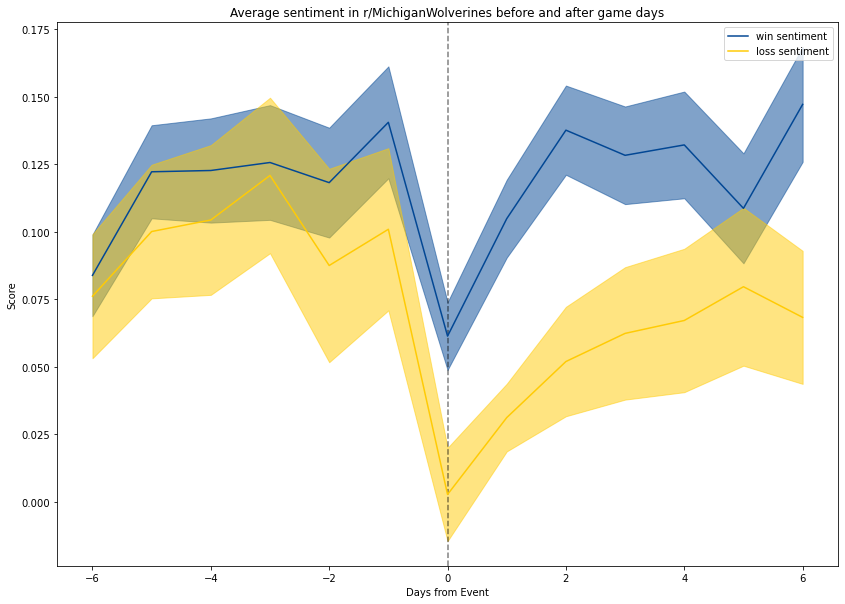

In [42]:
make_plot2([win_days, loss_days], names=['win', 'loss'],
           columns='sentiment', colors='UM',
           title='Average sentiment in r/MichiganWolverines before and after game days')


#### Short Answer 9:
Why is sentiment worse on game days, even when we win?
- Before going further, let's think about what could cause the average sentiment of all comments to go down on game days. There are two possibilities:
    1. A higher percent of comments are negative on game days than on other days.
    2. The negative comments are *more negative* and/or the positive comments are *less positive* on game days
- In a few sentences, say **whether** you think one, both, or neither of these is happening, and **why**. This is your hypothesis.

🤔**Write your response here:**
....

#### Next:
- In the next part, we separate out comments not by whether we won or lost the game that day, but by whether their sentiment was positive or negative. That will help us answer these questions:
    - Are there more negative comments on game days? 
    - Fewer positive ones?
    - Do the postive comments get *less* positive on game days? 
    - Do the negative ones get *more* negative?

#### Short Answer 10:
- 1. **What hypotheses** do you have about (a) the number of positive and negative comments on game days and (b) the intensity of postive and negative comments on game days? 
- 2. After looking at the data, write a few sentences saying **whether** your observation supports your hypotheses and **why**. These are your preliminary findings.

#### Helper functions

In [43]:
game_pos = center_on_dates(sports_comments[sports_comments.sentiment > 0], 
                          games, window_size=6)
game_neg = center_on_dates(sports_comments[sports_comments.sentiment < 0], 
                           games[games.game_result == 'W'], 
                           window_size=6)

def make_plot3(grouped, title=None, 
                colors='vega', names = None):
    
    color_sets = {'UM': ['#024794', '#ffcb05', '#83b2a8',
                         '#989c97', '#7a121c'],
                  'vega': ['#1f77b4', '#ff7f0e', '#2ca02c', 
                           '#d62728', '#9467bd', '#8c564b',
                           '#e377c2', '#7f7f7f', '#bcbd22']}
    
    fig, axs = plt.subplots(figsize=(14,10))
                    
    if not isinstance(grouped, list):
        grouped = [grouped]
        names=['']
        
    scheme = color_sets[colors]
          
    axs.axvline(0, color='k', linestyle='dashed', alpha=.5)
    i = 0
    
    df = pd.DataFrame()
    
    for g, n in zip(grouped, names):                    
        tmp = g[['id']].count().copy()
        tmp.columns = [n]
        df = df.merge(tmp, left_index=True, right_index=True, how='outer')
        
    totals = df.sum(axis=1)
    for c in df.columns:
        df[c] = df[c] / totals
        
    axs.stackplot(df.index, df.T, labels=df.columns, colors=scheme)
        
    if title is None:
        title = 'Percent of comments'
    else:
        axs.set_title(title)
        
    axs.set_ylabel('Percent')          
    axs.set_xlabel('Days from Event')
    axs.legend()
                
    plt.show()
    return


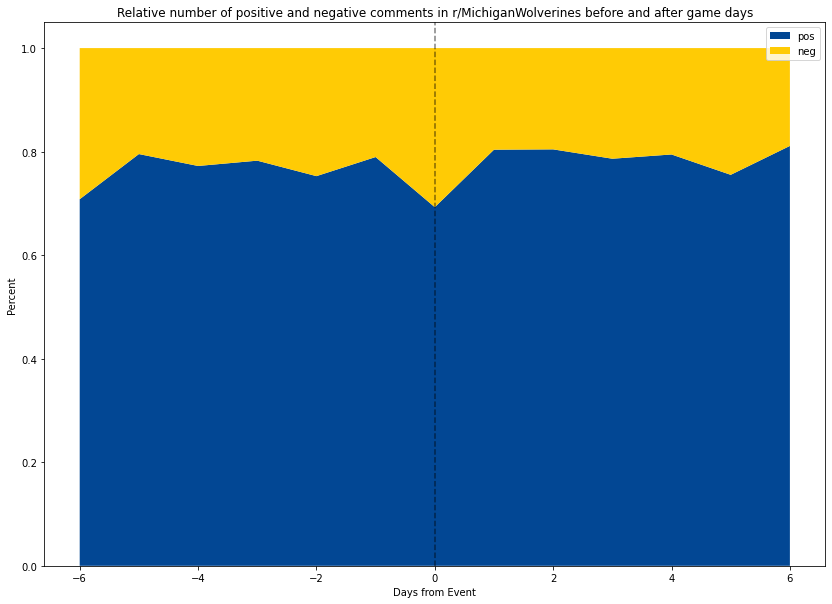

In [44]:
make_plot3([game_pos, game_neg], names=['pos', 'neg'],
           colors='UM',
           title='Relative number of positive and negative comments in r/MichiganWolverines before and after game days')


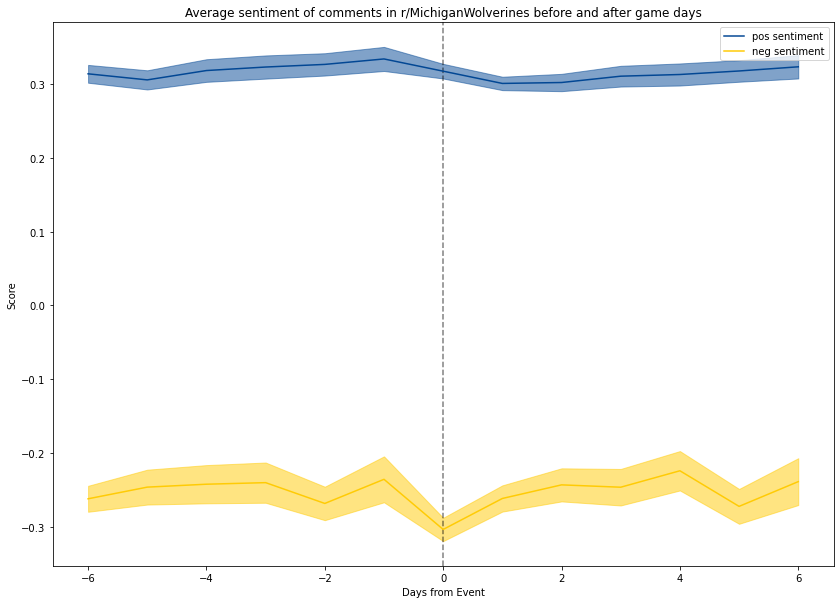

In [45]:
make_plot2([game_pos, game_neg], names=['pos', 'neg'],
           columns='sentiment', colors='UM',
           title='Average sentiment of comments in r/MichiganWolverines before and after game days')


🤔**Write your response here:**
....

## What we learned:
1. What reddit is, and what comment data looks like.
2. Various ways of scoring comments to summarize their contents.
3. The difficulty of getting good scores.
4. Grouping data by time and showing trends in average comment scores.
5. Comparing time series data with events.

### Reflection 1: write a brief proposal:
Write a **2-paragraph proposal** to expand on the analysis of the cause of low sentiment on game days.  
- 1. (One of the explanations is that Saturdays cause negative sentiments - see optional for the analysis.) What **other causes** can you think of? 
- 2. What could you do to further **test** your preliminary findings? That is, what additional analysis could you do to check if they were right? (You don't need to actually do the analysis.) 
- *Hints*:
    - What other scores you want to look at (that might be related to sentiment)?  Why?
        - recall SA4: there is a inverse relationship between toxicity and sentiment. Are there relationships between sentiment and other scores?
    - Are there outside factors that might be causing the pattern we see? What are they, and how might you test them? 

🤔**Write your proposal here:**
.
.
.
.
.

# Optional

## Do Saturdays cause negative comments? 
- This code will help us find out!

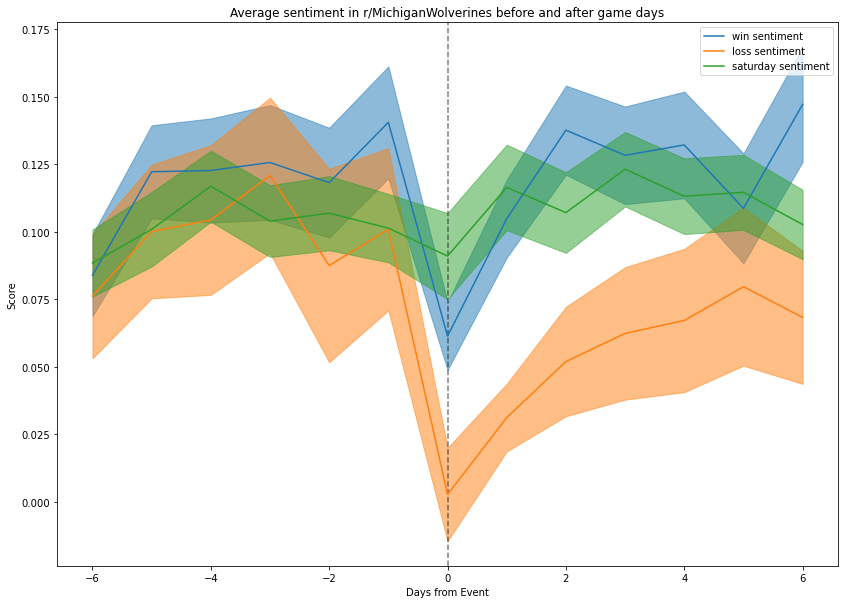

In [46]:
from datetime import timedelta

def get_dates(from_date, to_date, day_list=[5]):
    tmp_list = list()
    date_list = list()
    for x in range((to_date - from_date).days+1):
        tmp_list.append(from_date + timedelta(days=x))
    for date_record in tmp_list:
        if date_record.weekday() in day_list:
            date_list.append(date_record)
 
    return date_list

dates = get_dates(datetime(year=2012, month=1, day=1), 
          datetime(year=2018, month=1, day=1), 
          day_list=[5])

gd = set(games.date.tolist())

sats = pd.DataFrame(dates).rename(columns={0: 'date'})
sats = set(sats.date) - gd
sats = pd.DataFrame(list(sats)).rename(columns={0: 'date'})

saturdays = center_on_dates(sports_comments, 
                            sats, window_size=6)

make_plot2([win_days, loss_days, saturdays], 
           names=['win', 'loss', 'saturday'],
           columns='sentiment', colors='vega',
           title='Average sentiment in r/MichiganWolverines before and after game days')

## Looks like game days are worse than regular Saturdays!